<div style="text-align:center">
    <h1><b>KLASIFIKASI IKAN SEHAT DENGAN IKAN TERINFEKSI PENYAKIT BERDASARKAN CITRA KULITNYA</b></h1>
    <h1><b></b></h1>
</div>
<br><br>
<br><br>
<table style="width:100%;">
    <tr>
        <td align="center">
            <img src="UNRAM-LOGO.png" alt="Foto" width="500" height="500">
        </td>
    </tr>
</table>
<br><br>
<br><br>
<div style="text-align:center">
    <h2>Disusun Oleh:</h2>
    <h2>MUHAMMAD ADHITYA NUGRAHA: F1D02310016</h2>
    <h2>MUHAMMAD RIDHO AIDIL FURQON: F1D02310127</h2>
    <h2>IRFAN JAYADI: F1D02310011<h2>
    <h2>MUHAMMAD FARUK WIRA PRABUANA JAMALUDIN: F1D02310147</h2>
</div>
<br><br><br><br>
<br><br><br><br>
<div style="text-align:center">
    <h2>UNIVERSITAS MATARAM</h2>
    <h2>FAKULTAS TEKNIK</h2>
    <h2>TEKNIK INFORMATIKA</h2>
    <h2>2024/2025</h2>
</div>
<br><br><br><br>
<br><br><br><br>
<br><br><br><br>
<br><br><br><br>


## Latar Belakang


In [158]:
# Import library yang kalian butuhkan
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

DATA LOADING

In [159]:
data = []
labels = []
file_name = []
target_size = (256, 256)
for sub_folder in os.listdir("Dataset"):
    sub_folder_files = os.listdir(os.path.join("Dataset", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("Dataset", sub_folder, filename)
        img = cv.imread(img_path)
        img = img.astype(np.uint8)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        img = cv.resize(img, target_size)

        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)
        
data = np.array(data)
labels = np.array(labels)



Data Understanding

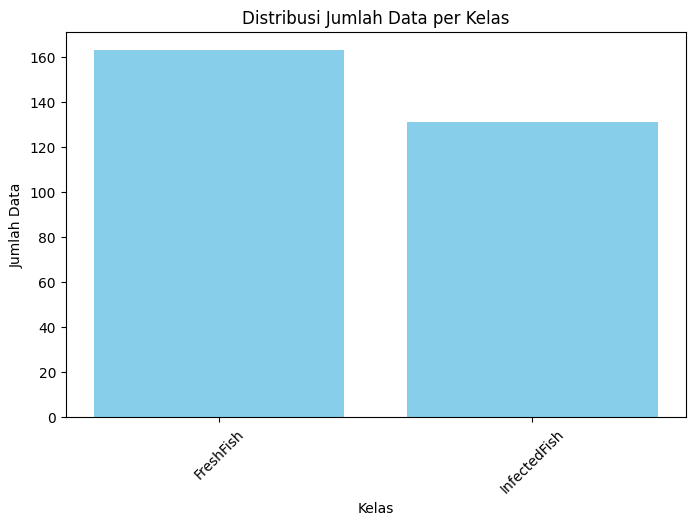

In [160]:
# Menampilkan jumlah data per kelas
unique_labels, counts = np.unique(labels, return_counts=True)
plt.figure(figsize=(8, 5))
plt.bar(unique_labels, counts, color='skyblue')
plt.xlabel("Kelas")
plt.ylabel("Jumlah Data")
plt.title("Distribusi Jumlah Data per Kelas")
plt.xticks(rotation=45)
plt.show()

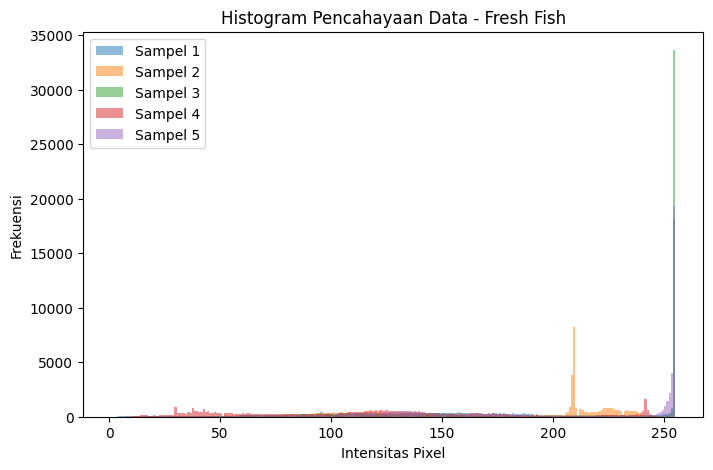

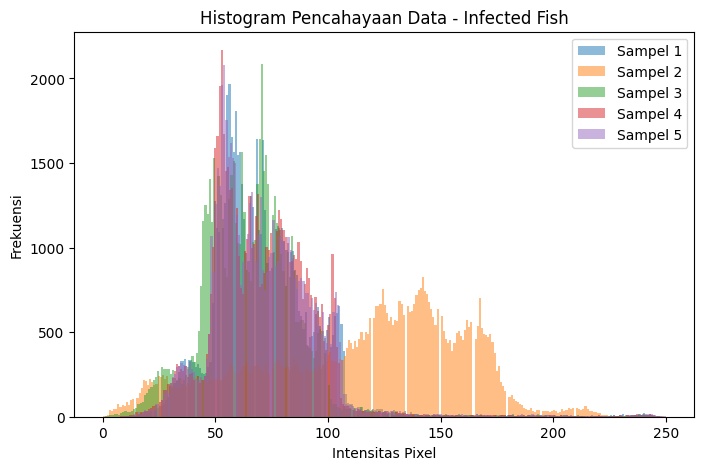

In [161]:
fresh_fish_samples = [data[i] for i in range(len(labels)) if labels[i] == "FreshFish"]
infected_fish_samples = [data[i] for i in range(len(labels)) if labels[i] == "InfectedFish"]

plt.figure(figsize=(8, 5))
for i in range(min(5, len(fresh_fish_samples))):
    img = fresh_fish_samples[i]
    plt.hist(img.ravel(), bins=256, alpha=0.5, label=f'Sampel {i+1}')
plt.xlabel("Intensitas Pixel")
plt.ylabel("Frekuensi")
plt.title("Histogram Pencahayaan Data - Fresh Fish")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i in range(min(5, len(infected_fish_samples))):  
    img = infected_fish_samples[i]
    plt.hist(img.ravel(), bins=256, alpha=0.5, label=f'Sampel {i+1}')
plt.xlabel("Intensitas Pixel")
plt.ylabel("Frekuensi")
plt.title("Histogram Pencahayaan Data - Infected Fish")
plt.legend()
plt.show()

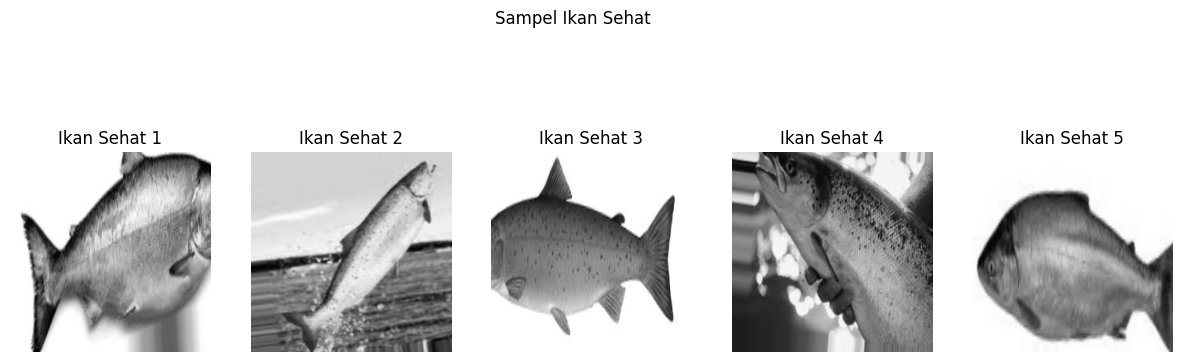

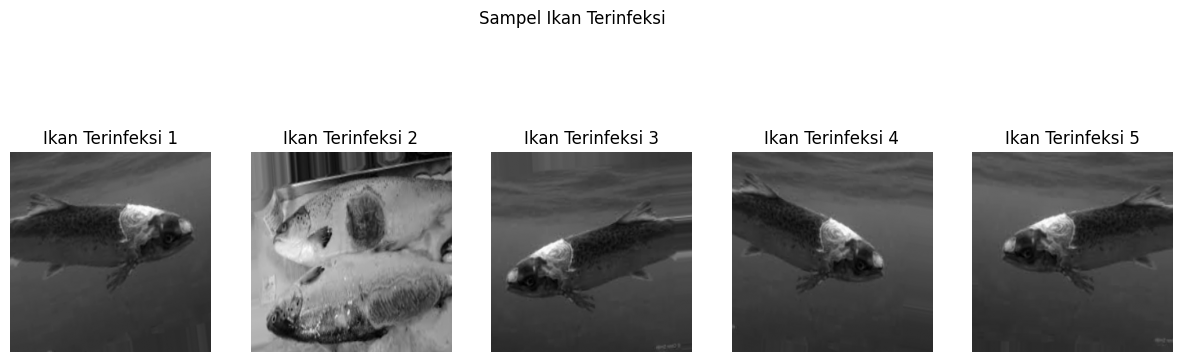

In [162]:
# Menampilkan sampel ikan sehat
fig, axes = plt.subplots(1, min(5, len(fresh_fish_samples)), figsize=(15, 5))
for i in range(min(5, len(fresh_fish_samples))):  # Menampilkan hingga 5 sampel
    axes[i].imshow(fresh_fish_samples[i], cmap="gray")
    axes[i].set_title(f"Ikan Sehat {i+1}")
    axes[i].axis("off")
plt.suptitle("Sampel Ikan Sehat")
plt.show()

fig, axes = plt.subplots(1, min(5, len(infected_fish_samples)), figsize=(15, 5))
for i in range(min(5, len(infected_fish_samples))):  # Menampilkan hingga 5 sampel
    axes[i].imshow(infected_fish_samples[i], cmap="gray")
    axes[i].set_title(f"Ikan Terinfeksi {i+1}")
    axes[i].axis("off")
plt.suptitle("Sampel Ikan Terinfeksi")
plt.show()

DEFINE DATA AUGMENTATION

In [163]:
# melakukan augmentasi data
data_augmented = []
labels_augmented = []
paths_augmented = []
file_name_augmented = []
for i in range(len(data)):
	img = data[i]
	label = labels[i]
	filename = file_name[i]

    # Augmentasi Flip Horizontal & Vertikal
	img_flip_h = cv.flip(img, 1)  # Flip horizontal
	img_flip_v = cv.flip(img, 0)  # Flip vertikal

    # Augmentasi Rotasi 90° & 180°
	img_rot_90 = cv.rotate(img, cv.ROTATE_90_CLOCKWISE)
	img_rot_180 = cv.rotate(img, cv.ROTATE_180)

    # Augmentasi Translasi (Shift)
	rows, cols = img.shape[:2]
	M_trans = np.float32([[1, 0, 20], [0, 1, 20]])  # Geser 20 pixel kanan & bawah
	img_translated = cv.warpAffine(img, M_trans, (cols, rows))

	for augmented_img, suffix in [(img_flip_h, "flip_h"), (img_flip_v, "flip_v"), (img_rot_90, "rot_90"), (img_rot_180, "rot_180"), (img_translated, "translated")]:
		data_augmented.append(augmented_img)
		labels_augmented.append(label)
		file_name_augmented.append(f"{filename}_{suffix}")

print("Data sebelum augmentasi: ", len(data))
print("Data setelah augmentasi: ", len(data_augmented))


Data sebelum augmentasi:  294
Data setelah augmentasi:  1470


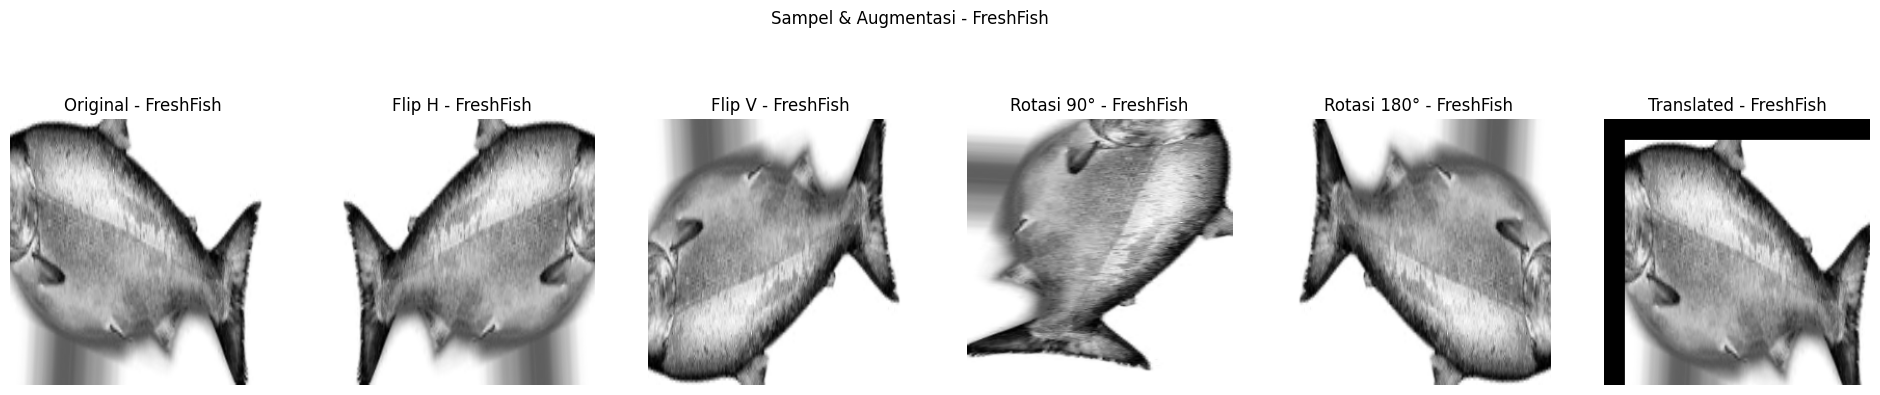

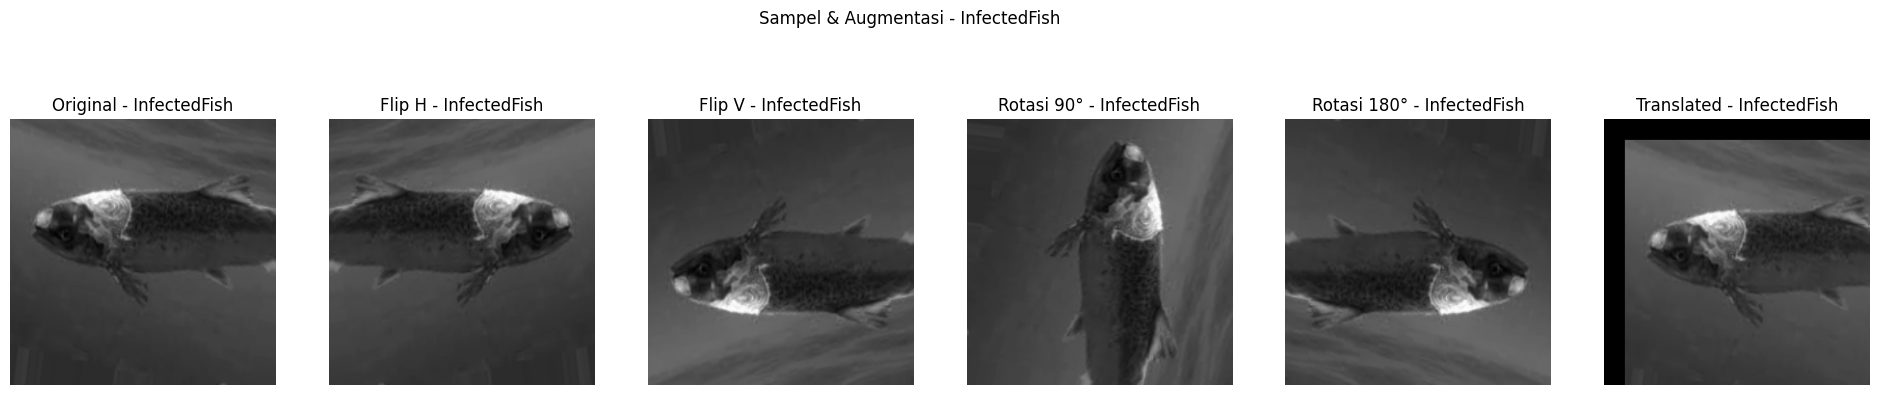

In [164]:
unique_labels = np.unique(labels_augmented)
for label in unique_labels:
    samples = [data_augmented[i] for i in range(len(labels_augmented)) if labels_augmented[i] == label]

    if len(samples) > 0:
        sample_img = samples[0]  # Pilih satu gambar pertama
        
        # Melakukan augmentasi tambahan dengan translasi
        rows, cols = sample_img.shape[:2]
        M_trans = np.float32([[1, 0, 20], [0, 1, 20]])  # Geser 20 pixel ke kanan & bawah
        img_translated = cv.warpAffine(sample_img, M_trans, (cols, rows))

        # Membuat kanvas baru untuk setiap label
        fig, axes = plt.subplots(1, 6, figsize=(24, 5))  # 1 baris, 6 kolom
        augment_titles = ["Original", "Flip H", "Flip V", "Rotasi 90°", "Rotasi 180°", "Translated"]

        # Augmentasi
        augmentations = [
            sample_img,
            cv.flip(sample_img, 1),  # Flip horizontal
            cv.flip(sample_img, 0),  # Flip vertikal
            cv.rotate(sample_img, cv.ROTATE_90_CLOCKWISE),  # Rotasi 90°
            cv.rotate(sample_img, cv.ROTATE_180),  # Rotasi 180°
            img_translated  # Translasi
        ]

        # Menampilkan semua augmentasi dalam kanvas
        for i in range(6):
            axes[i].imshow(augmentations[i], cmap="gray")
            axes[i].set_title(f"{augment_titles[i]} - {label}")
            axes[i].axis("off")
        
        plt.suptitle(f"Sampel & Augmentasi - {label}")
        plt.show()

PREPROSSESING

In [165]:
def normalize(img):
    return cv.normalize(img, None, 0, 255, cv.NORM_MINMAX)

def histogram_equalization(img):
    return cv.equalizeHist(img)

def mean_filter(img, ksize=3):
    return cv.blur(img, (ksize, ksize))

def median_filter(img, ksize=3):
    return cv.medianBlur(img, ksize)

def morphological_opening(img, ksize=3):
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (ksize, ksize))
    return cv.morphologyEx(img, cv.MORPH_OPEN, kernel)

def morphological_closing(img, ksize=3):
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (ksize, ksize))
    return cv.morphologyEx(img, cv.MORPH_CLOSE, kernel)

def prewitt_operator(img):
    kernelx = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
    kernely = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
    x = cv.filter2D(img, -1, kernelx)
    y = cv.filter2D(img, -1, kernely)
    return cv.addWeighted(x, 0.5, y, 0.5, 0)


In [166]:
def prepro1(img):
    norm = normalize(img)
    eq = histogram_equalization(norm)
    return eq

# Percobaan 2: + Mean + Median filter
def prepro2(img):
    norm = normalize(img)
    eq = histogram_equalization(norm)
    mean = mean_filter(eq)
    median = median_filter(mean)
    return median

# Percobaan 3: + Opening + Closing + Prewitt
def prepro3(img):
    norm = normalize(img)
    eq = histogram_equalization(norm)
    mean = mean_filter(eq)
    median = median_filter(mean)
    open_ = morphological_opening(median)
    close = morphological_closing(open_)
    prewitt = prewitt_operator(close)
    return prewitt

In [167]:
dataPreprocessed_1 = []
dataPreprocessed_2 = []
dataPreprocessed_3 = []

for i in range(len(data)):
    img = data[i]
    dataPreprocessed_1.append(prepro1(img))
    dataPreprocessed_2.append(prepro2(img))
    dataPreprocessed_3.append(prepro3(img))

percobaan_ke = 1  

if percobaan_ke == 1:
    dataPreprocessed = dataPreprocessed_1
elif percobaan_ke == 2:
    dataPreprocessed = dataPreprocessed_2
elif percobaan_ke == 3:
    dataPreprocessed = dataPreprocessed_3
else:
    raise ValueError("Hanya mendukung percobaan ke-1, 2, atau 3.")

FEATURE EXTRACTION

In [168]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [169]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [170]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [171]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [172]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [173]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [174]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [175]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [176]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [177]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

In [178]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [179]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [180]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [181]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [182]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [183]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [184]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

Write the extraction's results to CSV

In [185]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak

,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,aug_0_1014.png,FreshFish,248.852558,325.909512,103.347381,289.155002,0.393899,0.367978,0.481425,0.380177,...,0.074063,0.070476,0.267786,0.265140,0.272146,0.265473,0.982991,0.977689,0.992938,0.980206
1,aug_0_1086.png,FreshFish,154.095941,382.687336,221.934038,262.092195,0.426751,0.286261,0.330013,0.316736,...,0.014250,0.013701,0.127284,0.115357,0.119375,0.117053,0.986370,0.966172,0.980392,0.976832
2,aug_0_1122.png,FreshFish,418.249908,500.666190,232.690487,510.130396,0.626892,0.606500,0.676195,0.606413,...,0.256047,0.248625,0.502553,0.499066,0.506011,0.498623,0.978849,0.974692,0.988234,0.974213
3,aug_0_1126.png,FreshFish,306.383747,397.283968,178.317065,446.820515,0.255278,0.207725,0.285019,0.195672,...,0.001059,0.000780,0.030129,0.028222,0.032543,0.027937,0.971723,0.963275,0.983526,0.958696
4,aug_0_1157.png,FreshFish,195.031633,244.084952,110.087561,254.940146,0.509113,0.474131,0.569527,0.461810,...,0.084866,0.078722,0.285216,0.281086,0.291317,0.280574,0.987080,0.983807,0.992708,0.983087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,aug_0_9651.png,InfectedFish,309.942126,440.226667,193.714675,474.193695,0.227539,0.172221,0.258030,0.172299,...,0.000932,0.000571,0.027603,0.023941,0.030529,0.023899,0.971565,0.959663,0.982266,0.956551
290,aug_0_9685.png,InfectedFish,407.565411,528.413026,219.798744,579.561799,0.308348,0.255754,0.320640,0.248582,...,0.001611,0.001156,0.037872,0.034176,0.040133,0.033998,0.962920,0.951855,0.979964,0.947196
291,aug_0_9735.png,InfectedFish,211.769439,355.705375,170.447074,327.216332,0.343674,0.289900,0.363643,0.271027,...,0.000830,0.000561,0.027372,0.024253,0.028805,0.023693,0.980402,0.967039,0.984237,0.969679
292,aug_0_9830.png,InfectedFish,240.274311,347.405613,146.147809,357.959231,0.266208,0.206493,0.270875,0.190771,...,0.000926,0.000603,0.029481,0.025467,0.030436,0.024553,0.977995,0.968211,0.986626,0.967246


<Axes: >

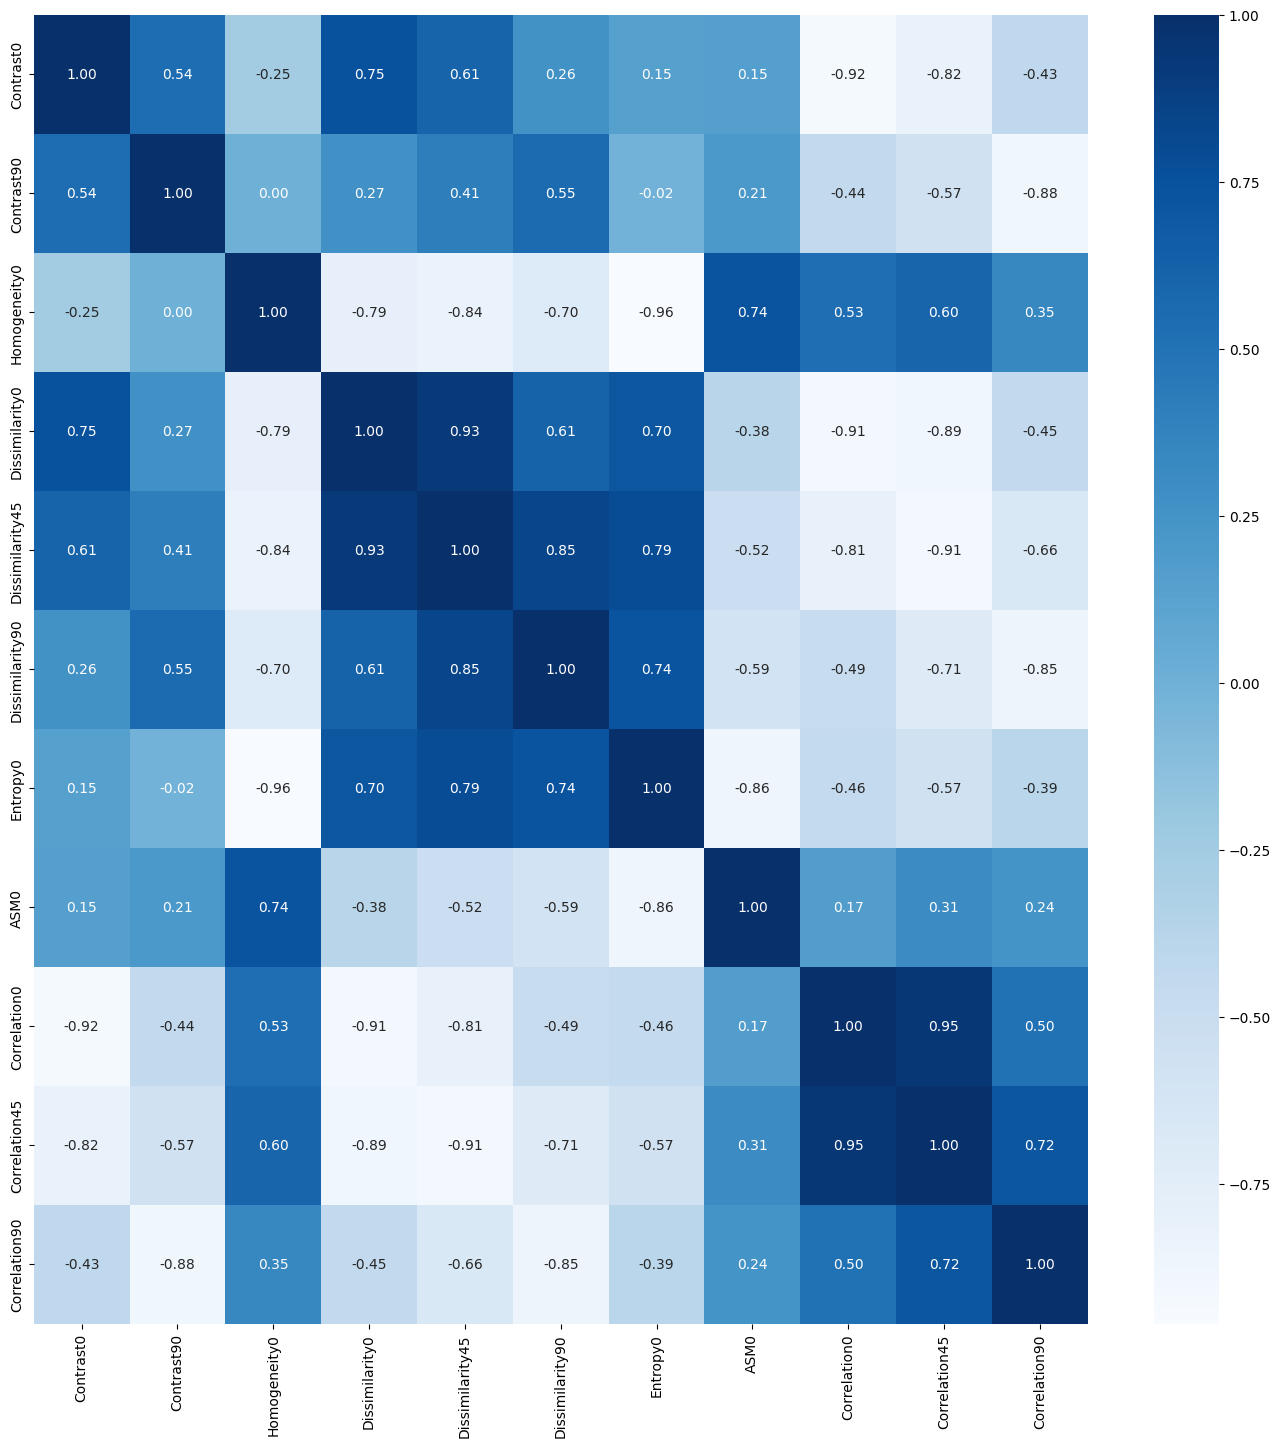

In [186]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

Splitting Data

In [187]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(235, 11)
(59, 11)


Feature Normalization

In [188]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

Modeling
Define Model

In [189]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

Train Random Forest Classifier

In [190]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

   FreshFish       1.00      1.00      1.00       129
InfectedFish       1.00      1.00      1.00       106

    accuracy                           1.00       235
   macro avg       1.00      1.00      1.00       235
weighted avg       1.00      1.00      1.00       235

[[129   0]
 [  0 106]]
Accuracy: 1.0

------Testing Set------
              precision    recall  f1-score   support

   FreshFish       0.94      1.00      0.97        34
InfectedFish       1.00      0.92      0.96        25

    accuracy                           0.97        59
   macro avg       0.97      0.96      0.96        59
weighted avg       0.97      0.97      0.97        59

[[34  0]
 [ 2 23]]
Accuracy: 0.9661016949152542


Train SVM Classifier

In [191]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

   FreshFish       0.94      0.84      0.89       129
InfectedFish       0.83      0.93      0.88       106

    accuracy                           0.89       235
   macro avg       0.89      0.89      0.88       235
weighted avg       0.89      0.89      0.89       235

[[109  20]
 [  7  99]]
Accuracy: 0.8851063829787233

------Testing Set------
              precision    recall  f1-score   support

   FreshFish       0.94      0.94      0.94        34
InfectedFish       0.92      0.92      0.92        25

    accuracy                           0.93        59
   macro avg       0.93      0.93      0.93        59
weighted avg       0.93      0.93      0.93        59

[[32  2]
 [ 2 23]]
Accuracy: 0.9322033898305084


Train KNN Classifier

In [192]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

   FreshFish       0.98      0.98      0.98       129
InfectedFish       0.98      0.97      0.98       106

    accuracy                           0.98       235
   macro avg       0.98      0.98      0.98       235
weighted avg       0.98      0.98      0.98       235

[[127   2]
 [  3 103]]
Accuracy: 0.9787234042553191

------Testing Set------
              precision    recall  f1-score   support

   FreshFish       0.97      0.97      0.97        34
InfectedFish       0.96      0.96      0.96        25

    accuracy                           0.97        59
   macro avg       0.97      0.97      0.97        59
weighted avg       0.97      0.97      0.97        59

[[33  1]
 [ 1 24]]
Accuracy: 0.9661016949152542


Evaluation With Confusion Matrix

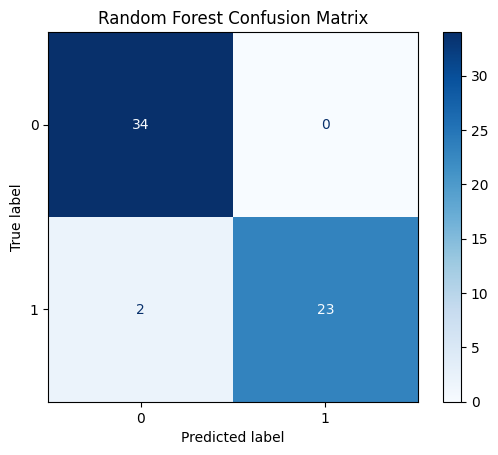

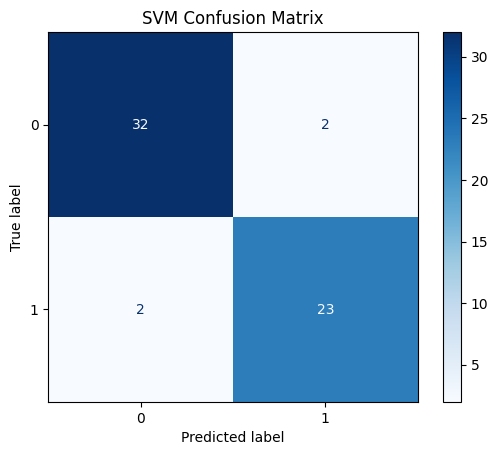

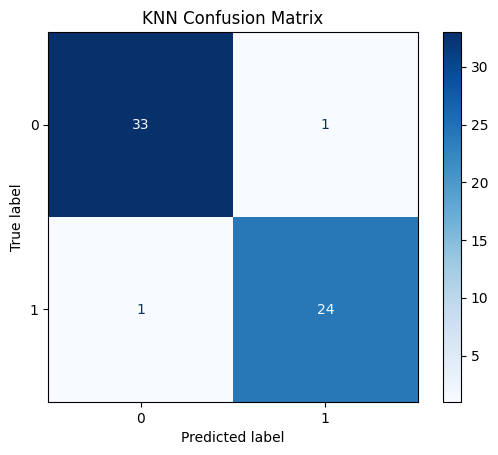

In [193]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")